# Common Library 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Measure Cosine Similarity of Embeddings

Here, we measure cosine similarity of embeddings in SO-3 Equivariant Method. 

Our SO-3 Equivariant Method starts with all same embeddings and learn to differ from rank injection.

The cosine similarity is measured layer by layer.

We import the needed libraries here

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint_sequential
import pytorch_warmup as warmup
import numpy as np
import random
import time
from copy import deepcopy
from tqdm import tqdm
from multimethod import multimethod
import argparse
import logging
from model import parse_point_architecture
from data.dataset import ModelNetDataLoader
import warnings

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from layer import TransformerEncoderBlock, ClassificationHead, SegmentationHead, RegressionHead

warnings.filterwarnings('ignore')

We load the dataset here here

In [3]:
root = "./datasets"
uniform = True
input_mask = True
use_normal = True
num_points = 1024
batch_size = 32
num_classes = 40

data_path = os.path.join(root, "modelnet40_normal_resampled")
train_dataset = ModelNetDataLoader(data_path, 
                        num_category=num_classes,
                        split='train', 
                        process_data=uniform,
                        transforms=input_mask,
                        use_uniform_sample=uniform,
                        use_normals=use_normal,
                        num_point=num_points)

test_dataset = ModelNetDataLoader(data_path, 
                        num_category=num_classes,
                        split='test', 
                        process_data=uniform,
                        transforms=input_mask,
                        use_uniform_sample=uniform,
                        use_normals=use_normal,
                        num_point=num_points)

trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

The size of train data is 9843
Load processed data from ./datasets/modelnet40_normal_resampled/modelnet40_train_1024pts_fps.dat...
The size of test data is 2468
Load processed data from ./datasets/modelnet40_normal_resampled/modelnet40_test_1024pts_fps.dat...


We load the trained model here (SO3)

In [4]:
model_str = "LIN,256@TRAN,256,16,256,0.5,0.1,0.1,0.2,maxout,distsim,leakyrelu,LN,postnorm,8@CLFH,40,256,512,0.1"
model = parse_point_architecture(model_str, is_normal=use_normal, input_mask=input_mask).to('cuda:4')
model = model.eval()
model(torch.randn(32, 1024, 6, device='cuda:4'))

tensor([[-0.1134,  0.2451,  0.8487,  ...,  0.8716, -0.4986,  0.4964],
        [-0.1134,  0.2451,  0.8487,  ...,  0.8716, -0.4986,  0.4964],
        [-0.1134,  0.2451,  0.8487,  ...,  0.8716, -0.4986,  0.4964],
        ...,
        [-0.1134,  0.2451,  0.8487,  ...,  0.8716, -0.4986,  0.4964],
        [-0.1134,  0.2451,  0.8487,  ...,  0.8716, -0.4986,  0.4964],
        [-0.1134,  0.2451,  0.8487,  ...,  0.8716, -0.4986,  0.4964]],
       device='cuda:4', grad_fn=<CompiledFunctionBackward>)

In [5]:
PATH = "./checkpoints/modelnet_maxout_kddrebuttal_orig_so3/seed_18/model_best.pth"
state_dict = torch.load(PATH)['model_state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
model.layer_list

ModuleList(
  (0): Linear(in_features=6, out_features=256, bias=True)
  (1): TransformerEncoderBlock(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiHeadAttention(
          (SAM): PairwiseSAM(
            (pointwise): Sequential(
              (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
              (1): Linear(in_features=256, out_features=1, bias=True)
            )
          )
          (att): CMultiHeadAttention(
            (attention): Attention(
              (relative_function): OptimizedModule(
                (_orig_mod): pairwise_distance_similarity(
                  (pairwise_distance): pairwise_distance()
                )
              )
              (linear_w): Linear(in_features=2, out_features=16, bias=False)
              (linear_b): Linear(in_features=2, out_features=16, bias=False)
            )
            (w_c): Linear(in_features=256, out_features=16, bias=False)
            (w_q): Linear(in_featur

In [7]:
model.input_mask

True

In [8]:
xs = []

In [9]:
for pts, target in trainDataLoader:
    x = pts.to('cuda:4')
    x_ref_ = x[:, :, :3] * 1
    x_ref_ = model.normalization(x_ref_.reshape(-1, 1)).reshape(x_ref_.shape)
    x[:,:,:3] = x_ref_

    if model.is_normal is False and model.input_mask is True:
        x_ref = x[:, :, :3] * 1
        x[:, :, :3] = 1.0
    
    if model.is_normal is False and model.input_mask is False:
        x_ref = x[:, :, :3] * 1
    
    if model.is_normal is True and model.input_mask is True:
        x_ref = x[:, :, :6] * 1
        x[:, :, :6] = 1.0
    
    if model.is_normal is True and model.input_mask is False:
        x_ref = x[:, :, :6] * 1

    for i in range(len(model.layer_list)):
        if isinstance(model.layer_list[i], nn.LazyLinear) or isinstance(model.layer_list[i], nn.Linear):
            x = model.layer_list[i](x)
            xs.append(x)
        elif isinstance(model.layer_list[i], TransformerEncoderBlock):
            for j in range(len(model.layer_list[i].layers)):
                x = model.layer_list[i].layers[j](x, x_ref, None, None)
                xs.append(x)
            continue
        else:
            x = model.layer_list[i](x, None)
            xs.append(x)
    break

In [10]:
len(xs)

10

In [11]:
def pairwise_similarity(matrix_of_vectors):
    dot_product = matrix_of_vectors@matrix_of_vectors.t()
    norms = torch.sqrt(torch.einsum('ii->i', dot_product))
    similarities = dot_product/(norms[None]*norms[..., None])

    return similarities

In [12]:
len(xs)

10

In [205]:
lst = [torch.mean(pairwise_similarity(xs[i][1])).item() for i in range(len(xs) - 1)]

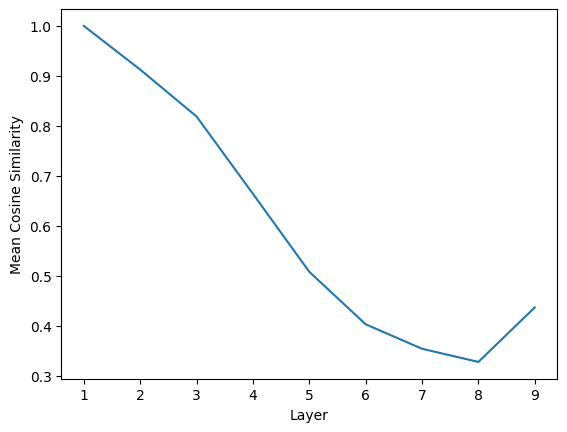

In [210]:
import matplotlib.pyplot as plt

plt.plot([i + 1 for i in range(len(lst))], lst)
plt.xlabel("Layer")
plt.ylabel("Mean Cosine Similarity")
plt.savefig(f"./ablation_study_plot/cosine_similarity/Cosine Similarity.pdf")
plt.show()
plt.close()

In [13]:
lst = [pairwise_similarity(xs[i][1]) for i in range(len(xs) - 1)]

In [16]:
lst_ = [torch.mean(lst[i], dim=-1) for i in range(len(lst))]

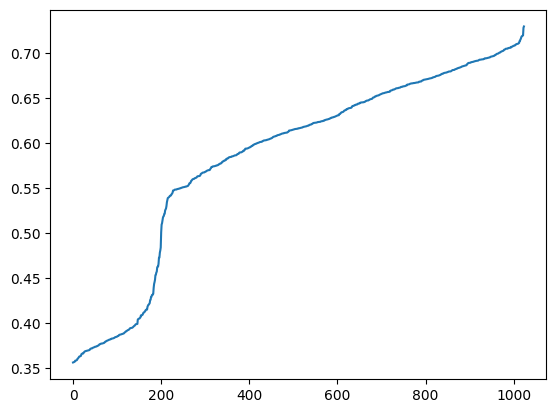

In [27]:
plt.plot(np.sort(lst_[8].to('cpu').detach().numpy()))

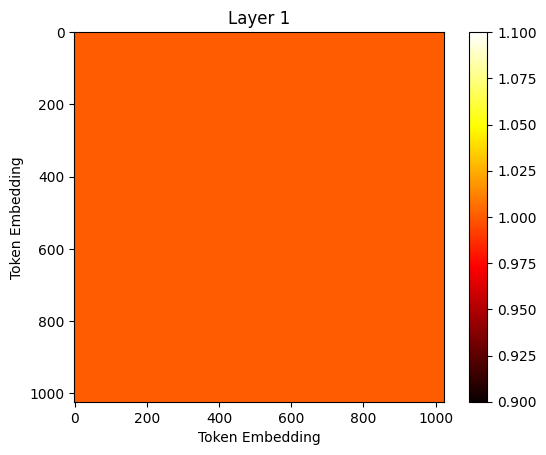

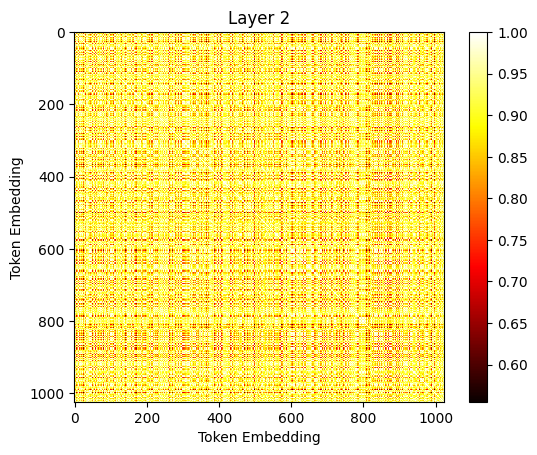

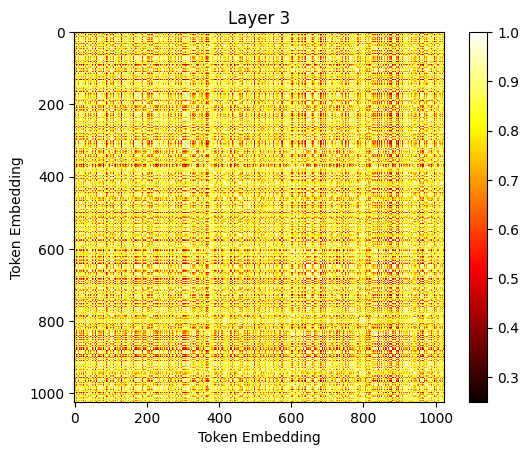

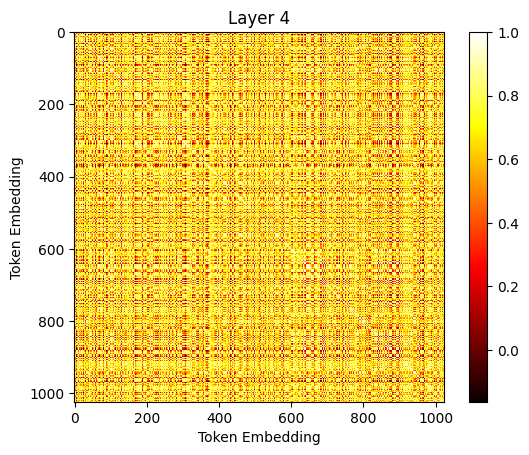

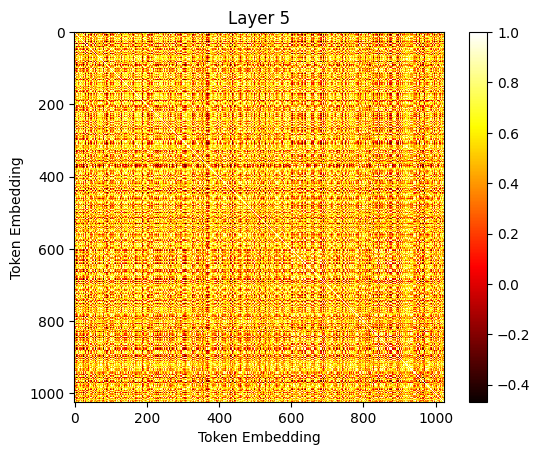

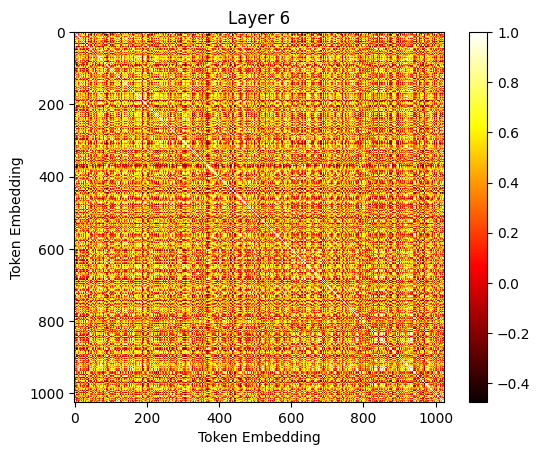

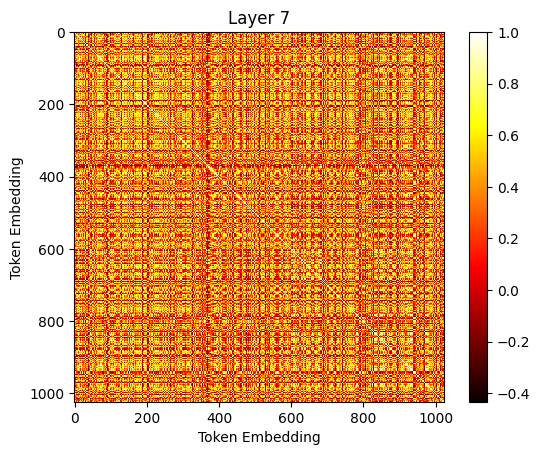

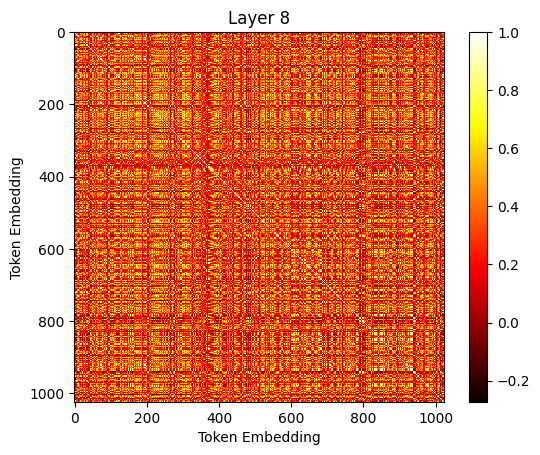

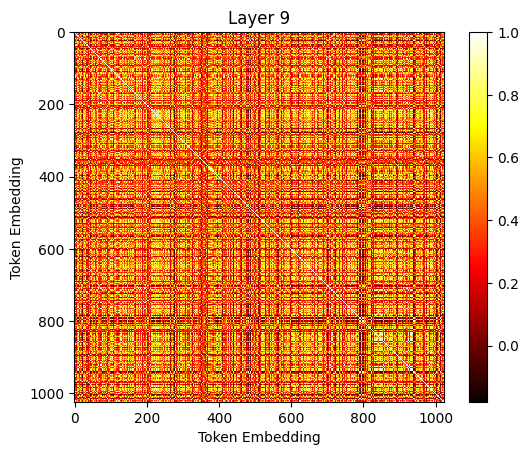

In [51]:
import torch

def plot_heatmaps_to_pdf(cosine_similarity_matrices):
    for i, similarity_matrix in enumerate(cosine_similarity_matrices):
        plt.figure()
        plt.title(f"Layer {i+1}")
        plt.imshow(similarity_matrix.to('cpu').detach().numpy(), cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.xlabel('Token Embedding')
        plt.ylabel('Token Embedding')
        plt.savefig(f"./ablation_study_plot/cosine_similarity/Layer {i+1}.pdf")
        plt.show()
        plt.close()

plot_heatmaps_to_pdf(lst)

# Load learning curves of different sampling rates

In [190]:
sampling_rate = ["0.4%", "6.25%", "12.5%", "25%", "50%"]
common = "./checkpoints/modelnet_maxout_kddrebuttal_orig"
training_log_paths = [common + "_4/seed_18/logs/training.log", 
                      common + "_64/seed_18/logs/training.log", 
                      common + "_128/seed_18/logs/training.log", 
                      common + "/seed_18/logs/training.log", 
                      common + "_512/seed_18/logs/training.log"]
file_contents = []

In [191]:
for i in range(len(training_log_paths)):
    f = open(training_log_paths[i])
    file_contents.append([line.rstrip('\n') for line in f])

In [192]:
def lines_to_learning_curve(lines):
    training_accuracy = []
    testing_accuracy = []
    cursor = 0
    for i in range(len(lines)):
        if lines[i] == 'Epoch 1':
            cursor = i

    while cursor < len(lines):
        lines_words = lines[cursor].split(',')
        if lines_words[0][:5] == "Train":
            training_accuracy.append(float(lines_words[0].split('=')[1]))
        if lines_words[0][:4] == "Test":
            testing_accuracy.append(float(lines_words[0].split('=')[1]))
        cursor += 1

    return training_accuracy, testing_accuracy

train_accs = []
test_accs = []

for i in range(len(sampling_rate)):
    train_acc, test_acc = lines_to_learning_curve(file_contents[i])
    train_accs.append(train_acc)
    test_accs.append(test_acc)

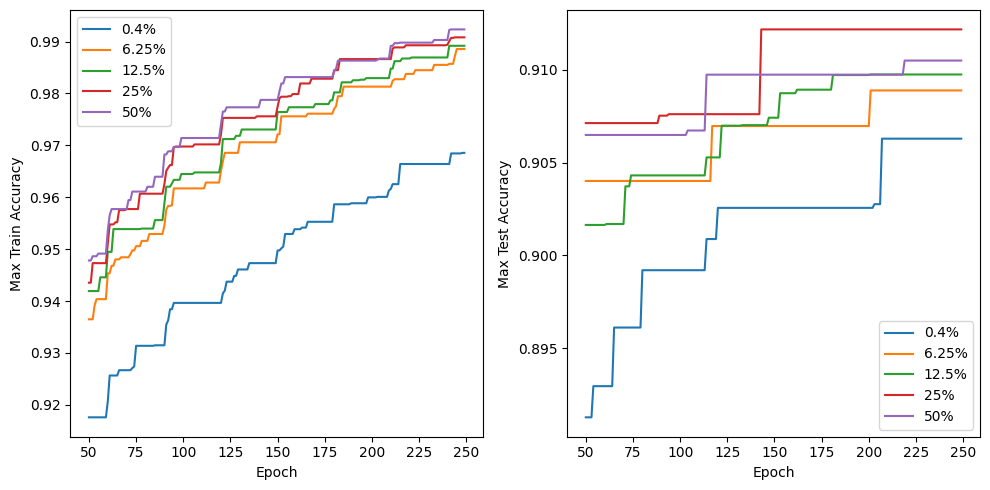

In [193]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(len(sampling_rate)):
    mxa = train_accs[i]
    for j in range(1, len(mxa)):
        mxa[j] = max(mxa[j], mxa[j - 1])
    sub = mxa[50:250]
    # sub = [max(test_accs[i][:50]), max(test_accs[i][:100]), max(test_accs[i][:150]), max(test_accs[i][:200]), max(test_accs[i][:250])]
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Max Train Accuracy')
    axs[0].plot([i + 50 for i in range(len(sub))],sub, label=sampling_rate[i])
axs[0].legend()

for i in range(len(sampling_rate)):
    mxa = test_accs[i]
    for j in range(1, len(mxa)):
        mxa[j] = max(mxa[j], mxa[j - 1])
    sub = mxa[50:250]
    # sub = [max(test_accs[i][:50]), max(test_accs[i][:100]), max(test_accs[i][:150]), max(test_accs[i][:200]), max(test_accs[i][:250])]
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Max Test Accuracy')
    axs[1].plot([i + 50 for i in range(len(sub))], sub, label=sampling_rate[i])
axs[1].legend()

# Adjust layout
plt.tight_layout()

plt.savefig(f"./ablation_study_plot/sampling_rate_performance/modelnet40.pdf")

# Show plots
plt.show()

# Load learning curve of leaky maxout versus softmax dot

In [213]:
sampling_rate = ["Softmax Dot", "LeakyReLU Maxout", "Vanilla Attention"]
common = "./checkpoints/modelnet_"
training_log_paths = [common + "maxout_kddrebuttal_orig_softmax_dot/seed_18/logs/training.log", 
                      common + "maxout_kddrebuttal_orig/seed_18/logs/training.log",  
                      common + "kddrebuttal_vanilla/seed_18/logs/training.log",]
file_contents = []

In [214]:
for i in range(len(training_log_paths)):
    f = open(training_log_paths[i])
    file_contents.append([line.rstrip('\n') for line in f])

In [215]:
def lines_to_learning_curve(lines):
    training_accuracy = []
    testing_accuracy = []
    cursor = 0
    for i in range(len(lines)):
        if lines[i] == 'Epoch 1':
            cursor = i

    while cursor < len(lines):
        lines_words = lines[cursor].split(',')
        if lines_words[0][:5] == "Train":
            training_accuracy.append(float(lines_words[0].split('=')[1]))
        if lines_words[0][:4] == "Test":
            testing_accuracy.append(float(lines_words[0].split('=')[1]))
        cursor += 1

    return training_accuracy, testing_accuracy

train_accs = []
test_accs = []

for i in range(len(sampling_rate)):
    train_acc, test_acc = lines_to_learning_curve(file_contents[i])
    train_accs.append(train_acc)
    test_accs.append(test_acc)

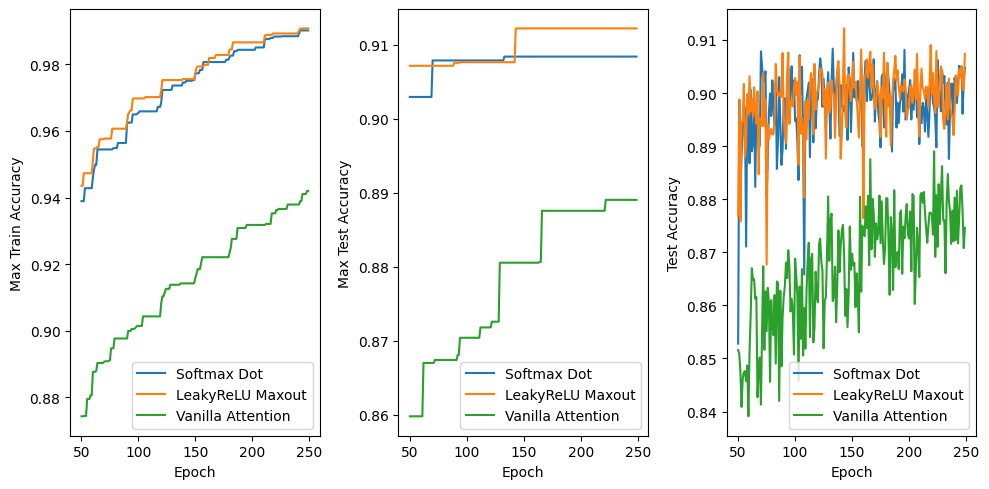

In [216]:
from copy import deepcopy

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

for i in range(len(sampling_rate)):
    mxa = train_accs[i]
    for j in range(1, len(mxa)):
        mxa[j] = max(mxa[j], mxa[j - 1])
    sub = mxa[50:250]
    # sub = [max(test_accs[i][:50]), max(test_accs[i][:100]), max(test_accs[i][:150]), max(test_accs[i][:200]), max(test_accs[i][:250])]
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Max Train Accuracy')
    axs[0].plot([i + 50 for i in range(len(sub))],sub, label=sampling_rate[i])
axs[0].legend()

for i in range(len(sampling_rate)):
    mxa = deepcopy(test_accs[i])
    for j in range(1, len(mxa)):
        mxa[j] = max(mxa[j], mxa[j - 1])
    sub = mxa[50:250]
    # sub = [max(test_accs[i][:50]), max(test_accs[i][:100]), max(test_accs[i][:150]), max(test_accs[i][:200]), max(test_accs[i][:250])]
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Max Test Accuracy')
    axs[1].plot([i + 50 for i in range(len(sub))],sub, label=sampling_rate[i])
axs[1].legend()

for i in range(len(sampling_rate)):
    mxa = test_accs[i]
    # for j in range(1, len(mxa)):
    #     mxa[j] = max(mxa[j], mxa[j - 1])
    sub = mxa[50:250]
    # sub = [max(test_accs[i][:50]), max(test_accs[i][:100]), max(test_accs[i][:150]), max(test_accs[i][:200]), max(test_accs[i][:250])]
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Test Accuracy')
    axs[2].plot([i + 50 for i in range(len(sub))],sub, label=sampling_rate[i])
axs[2].legend()

# Adjust layout
plt.tight_layout()

plt.savefig(f"./ablation_study_plot/softmax_leakyr/modelnet40.pdf")

# Show plots
plt.show()

# GELU vs ReLU

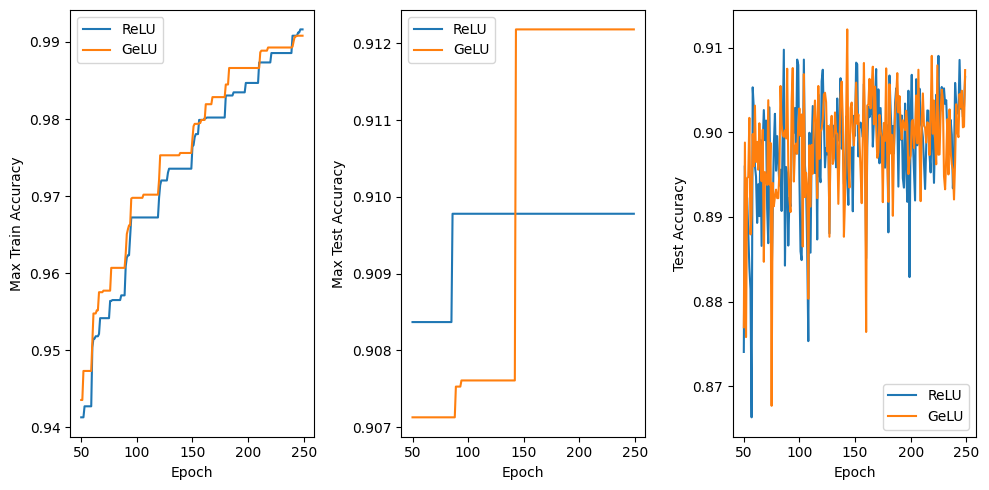

In [4]:
import matplotlib.pyplot as plt

sampling_rate = ["ReLU", "GeLU"]
common = "./checkpoints/modelnet_maxout_kddrebuttal_orig"
training_log_paths = [common + "_relu/seed_18/logs/training.log", 
                      common + "/seed_18/logs/training.log",]
file_contents = []

for i in range(len(training_log_paths)):
    f = open(training_log_paths[i])
    file_contents.append([line.rstrip('\n') for line in f])

def lines_to_learning_curve(lines):
    training_accuracy = []
    testing_accuracy = []
    cursor = 0
    for i in range(len(lines)):
        if lines[i] == 'Epoch 1':
            cursor = i

    while cursor < len(lines):
        lines_words = lines[cursor].split(',')
        if lines_words[0][:5] == "Train":
            training_accuracy.append(float(lines_words[0].split('=')[1]))
        if lines_words[0][:4] == "Test":
            testing_accuracy.append(float(lines_words[0].split('=')[1]))
        cursor += 1

    return training_accuracy, testing_accuracy

train_accs = []
test_accs = []

for i in range(len(sampling_rate)):
    train_acc, test_acc = lines_to_learning_curve(file_contents[i])
    train_accs.append(train_acc)
    test_accs.append(test_acc)

from copy import deepcopy

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

for i in range(len(sampling_rate)):
    mxa = train_accs[i]
    for j in range(1, len(mxa)):
        mxa[j] = max(mxa[j], mxa[j - 1])
    sub = mxa[50:250]
    # sub = [max(test_accs[i][:50]), max(test_accs[i][:100]), max(test_accs[i][:150]), max(test_accs[i][:200]), max(test_accs[i][:250])]
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Max Train Accuracy')
    axs[0].plot([i + 50 for i in range(len(sub))],sub, label=sampling_rate[i])
axs[0].legend()

for i in range(len(sampling_rate)):
    mxa = deepcopy(test_accs[i])
    for j in range(1, len(mxa)):
        mxa[j] = max(mxa[j], mxa[j - 1])
    sub = mxa[50:250]
    # sub = [max(test_accs[i][:50]), max(test_accs[i][:100]), max(test_accs[i][:150]), max(test_accs[i][:200]), max(test_accs[i][:250])]
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Max Test Accuracy')
    axs[1].plot([i + 50 for i in range(len(sub))],sub, label=sampling_rate[i])
axs[1].legend()

for i in range(len(sampling_rate)):
    mxa = test_accs[i]
    # for j in range(1, len(mxa)):
    #     mxa[j] = max(mxa[j], mxa[j - 1])
    sub = mxa[50:250]
    # sub = [max(test_accs[i][:50]), max(test_accs[i][:100]), max(test_accs[i][:150]), max(test_accs[i][:200]), max(test_accs[i][:250])]
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Test Accuracy')
    axs[2].plot([i + 50 for i in range(len(sub))],sub, label=sampling_rate[i])
axs[2].legend()

# Adjust layout
plt.tight_layout()

plt.savefig(f"./ablation_study_plot/relu_gelu/modelnet40.pdf")

# Show plots
plt.show()